<a href="https://colab.research.google.com/github/KimaniKibuthu/Fraud-Detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection

## Introduction

IEEE-CIS works across a variety of AI and machine learning areas, including deep neural networks, fuzzy systems, evolutionary computation, and swarm intelligence. Today they’re partnering with the world’s leading payment service company, Vesta Corporation, seeking the best solutions for fraud prevention industry, and now you are invited to join the challenge.

In this competition, you’ll benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. You also have the opportunity to create new features to improve your results.

If successful, you’ll improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.

## Methodology

The methodology for the problem will be:
* Data Understanding
* Data Cleaning, Exploration & Feature Engineering
* Modelling

## Scoring
The metric to be used is **ROC_AUC Score**.

The goal is to obtain a model with a score of **0.8** 

# Libraries, Variables & Functions

## Libraries

In [41]:
# General Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Modelling
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from functools import partial
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

## Variables & Functions

In [39]:
# Variables
RANDOM_STATE = 42
VARIANCE = 0.95
TRAIN_SIZE = 0.8
INITIALS = ['V', 'C']
TO_USE = ['V_0','V_4','V_66','V_26','V_17','card6','TransactionAmt',
          'D3','M4','C_0','C_1','M3']
WEIGHTS = {
    0: 0.5186,
    1: 13.9242
}



In [13]:
def null_handler(data):
  ''' 
  Takes in the dataframe and returns a clean dataframe with  no missing values
  '''

  # To drop ( with missing values greater than 50%)
  to_drop = [column for column in data.columns if data[column].isnull().mean() >= 0.5]
  new_data = data.drop(to_drop, axis=1)

  # Drop the rest of the missing values
  columns_with_null = [column for column in new_data.columns if new_data[column].isnull().mean() != 0]
  final_data = new_data.dropna(subset=columns_with_null).reset_index(drop=True)

  return final_data

In [14]:
def dimension_reducer(data, initial, variance):
  '''
  Reduces the dimension of a column
  '''
  # Instantiate Objects
  from sklearn.decomposition import PCA
  from sklearn.preprocessing import StandardScaler

  pca = PCA(variance)
  scaler = StandardScaler()

  # Columns to reduce
  cols = [column for column in data.columns if column.startswith(initial)]

  # Subset data
  subset = data[cols]

  # reduce dimensionality
  scaled = scaler.fit_transform(subset)
  reduced = pca.fit_transform(scaled)
  final_columns = pd.DataFrame(reduced, columns=[f'{initial}_{i}' for i in range(0, reduced.shape[1])])
  
  # Drop original columns
  new_data = data.drop(cols, axis=1)

  final_data = pd.concat([new_data, final_columns], axis=1)

  return final_data
  

In [9]:
def categorical_handler(data):
  '''
  Converts categorical data to numerical data
  '''
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()

  # Instantiate columns
  cols = [column for column in data.columns if data[column].dtype=='O']

  # Convert
  for column in cols:
    data[column] = le.fit_transform(data[column])

  return data

In [21]:
def clean_data(data, to_use, target_column, variance, column_initials, split):
  '''
  Returns data that can be used for modelling
  '''
  from sklearn.model_selection import train_test_split
  # Deal with null values
  without_null_df = null_handler(data)

  # Get dimensions reduced
  dimensions_reduced_df = dimension_reducer(without_null_df,
                                            column_initials[0],
                                            variance)
  
  dimensions_reduced_df = dimension_reducer(dimensions_reduced_df,
                                            column_initials[1],
                                            variance) 
  # Encode the data
  numerical_df = categorical_handler(dimensions_reduced_df)

  # Final data
  final_data = numerical_df[to_use]

  X = final_data.copy()
  y = numerical_df[target_column]

  # Split data
  x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                      train_size=split,
                                                      stratify=y)
  
  return x_train.reset_index(drop=True), x_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)
  


In [30]:
def model_trainer(models, x_train, y_train):
  '''
  Trains the model
  '''
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import roc_auc_score

  kf = StratifiedKFold(5)
  
  scores_0 = []
  scores_1 = []
  scores_2 = []
  scores = [scores_0, scores_1, scores_2]
  for index in kf.split(x_train, y_train):
    train_index, test_index = index[0], index[1]
    X_train, Y_train = x_train.loc[train_index], y_train.loc[train_index]
    X_test, Y_test = x_train.loc[test_index], y_train.loc[test_index]
    for i in range(len(models)):
      models[i].fit(X_train, Y_train)
      predictions = models[i].predict_proba(X_test)[:, 1]
      roc = roc_auc_score(Y_test, predictions)
      scores[i].append(roc)
    

  print(f'Model {models[0]} , roc_score: {np.mean(scores_0)}')
  print(f'Model {models[1]} , roc_score: {np.mean(scores_1)}')
  print(f'Model {models[2]} , roc_score: {np.mean(scores_2)}')

In [37]:
# View feature importance
def plot_feature_importance(trained_model, features_train):

    #Create arrays from feature importance and feature names
    feature_importance = trained_model.feature_importances_
    feature_names = features_train.columns

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.set_style('whitegrid')
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],
                palette='husl')
    #Add chart labels
    plt.title('FEATURE IMPORTANCES')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [49]:
def optimize(params, x, y, weights):

  model = LGBMClassifier(**params, class_weight=WEIGHTS)
  kf = StratifiedKFold(5)
  roc = []
  for idx in kf.split(x, y):
    train_idx, test_idx = idx[0], idx[1]
    x_train = x.loc[train_idx]
    y_train = y.loc[train_idx]

    x_test = x.loc[test_idx]
    y_test = y.loc[test_idx]

    model.fit(x_train, y_train)
    preds = model.predict_proba(x_test)[:, 1]
    error = roc_auc_score(y_test, preds)
    roc.append(error)

  return -1.0 * np.mean(roc)

# Data Obtainance

In [3]:
# Kaggle details
os.environ["KAGGLE_USERNAME"] = 'kimanikibuthu'
os.environ["KAGGLE_KEY"] = 'f85c0bb5d43058fddcce7902e1325677'

In [4]:
# Download data
!kaggle competitions download -c ieee-fraud-detection

  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 54.0MB/s]
 79% 41.0M/52.2M [00:03<00:01, 8.54MB/s]
100% 52.2M/52.2M [00:03<00:00, 17.0MB/s]
 86% 50.0M/58.3M [00:03<00:00, 11.5MB/s]
100% 58.3M/58.3M [00:03<00:00, 17.9MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 106MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 160MB/s]


In [5]:
# Unzip files
!unzip /content/sample_submission.csv.zip
!unzip /content/test_identity.csv.zip
!unzip /content/test_transaction.csv.zip
!unzip /content/train_identity.csv.zip
!unzip /content/train_transaction.csv.zip

Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  /content/test_identity.csv.zip
  inflating: test_identity.csv       
Archive:  /content/test_transaction.csv.zip
  inflating: test_transaction.csv    
Archive:  /content/train_identity.csv.zip
  inflating: train_identity.csv      
Archive:  /content/train_transaction.csv.zip
  inflating: train_transaction.csv   


In [6]:
# Store them in variables
submission = pd.read_csv('/content/sample_submission.csv')
train_identity = pd.read_csv('/content/train_identity.csv')
train_transaction = pd.read_csv('/content/train_transaction.csv')
test_transaction = pd.read_csv('/content/test_transaction.csv')
test_identity = pd.read_csv('/content/test_identity.csv')

# Data Cleaning

In [35]:
# Clean Data
x_train, x_test, y_train, y_test = clean_data(train_transaction,
                                             to_use= TO_USE,
                                             target_column='isFraud',
                                             variance=VARIANCE,
                                             column_initials=INITIALS,
                                             split=TRAIN_SIZE)

# Modelling

## Training & Evaluation

In [26]:
# Instantiate models
lgb = LGBMClassifier(class_weight=WEIGHTS)
forest = RandomForestClassifier(class_weight=WEIGHTS)
xgb = XGBClassifier(scale_pos_weight=27)

models = [forest, xgb, lgb]

In [36]:
model_trainer(models, x_train, y_train)

Model RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.5186, 1: 13.9242}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False) , roc_score: 0.8441309127288378
Model XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scal

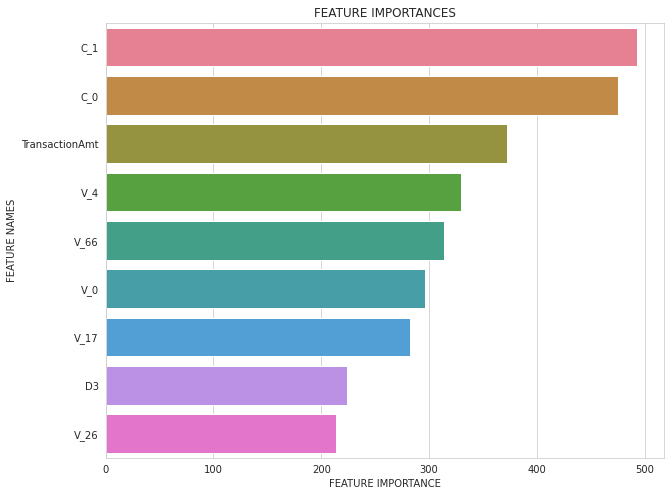

In [38]:
# View feature importances
plot_feature_importance(lgb, x_train)

## Hyperparameter Tune

In [50]:
# Define parameter space
param_space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 500, 50)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss'])
}

# Create optimization function
optimization_function = partial(optimize, x=x_train, y=y_train, weights=WEIGHTS)

# create Trial
trial = Trials()

# Optimize
result = fmin(
    fn=optimization_function,
    space=param_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trial
)


100%|██████████| 10/10 [07:02<00:00, 42.22s/it, best loss: -0.8551016238201198]


In [52]:
result

{'boosting_type': 2,
 'learning_rate': 0.028241581427160198,
 'n_estimators': 400.0}

In [53]:
## Train One last time

lgb = LGBMClassifier(boosting_type = 'goss',
                      learning_rate = 0.028241581427160198,
                      n_estimators = 400,
                     class_weight=WEIGHTS)

lgb.fit(x_train, y_train)

preds = lgb.predict_proba(x_test)[:, 1]

roc = roc_auc_score(y_test, preds)

print(f'The final ROC is : {roc}')

The final ROC is : 0.8715551550371068
